In [2]:
# install required libraries
!pip install sdv # install the synthetic data vault library
!pip install xlrd

In [3]:
# import data science libraries
import pandas as pd
import numpy as np
import math

# import scikit-learn preprocessing
from sklearn.preprocessing import LabelEncoder, QuantileTransformer

# import pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# import synthetic data vault libraries
from sdv.metadata import SingleTableMetadata
import sdv.evaluation.single_table as sdv_st

# import utility libraries
from tqdm import tqdm
import xlrd
import requests
from io import BytesIO
from zipfile import ZipFile
from datetime import datetime

# import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# set random seed
seed = 1234

# set dimension of categorical embeddings
cat_emb_dim = 2

# set number of neurons per layer
mlp_layers = [1024, 1024, 1024, 1024]

# set non-linear activation function
activation = 'lrelu'

# set number of diffusion steps
diffusion_steps = 500

# set diffusion start and end betas
diffusion_beta_start = 1e-4
diffusion_beta_end = 0.02

# set diffusion scheduler
scheduler = 'linear'

# set number of training epochs
epochs = 500

# set training batch size
batch_size = 512

# set training learning rate
learning_rate = 1e-4

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu").type

In [5]:
# set numpy seed
np.random.seed(seed)

# set pytorch seed
torch.manual_seed(seed)

# set cuda seed
torch.cuda.manual_seed(seed)

In [6]:
# read the UCI credit card dataset
train_raw =pd.read_csv('/kaggle/input/train-data/df_sample1.csv')

In [7]:
print("Nombre de doublons dans 'data' :", train_raw.duplicated().sum())

Nombre de doublons dans 'data' : 0


In [8]:
print("Nombre de doublons dans 'train_raw' :", train_raw.duplicated().sum())


Nombre de doublons dans 'train_raw' : 0


In [9]:
train_raw.shape

(455869, 53)

In [10]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455869 entries, 0 to 455868
Data columns (total 53 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Dst_Port                    455869 non-null  int64  
 1   Protocol                    455869 non-null  int64  
 2   Flow_Duration               455869 non-null  int64  
 3   Total_Fwd_Packet            455869 non-null  int64  
 4   Total_Bwd_packets           455869 non-null  int64  
 5   Total_Length_of_Fwd_Packet  455869 non-null  int64  
 6   Fwd_Packet_Length_Max       455869 non-null  int64  
 7   Fwd_Packet_Length_Min       455869 non-null  int64  
 8   Fwd_Packet_Length_Mean      455869 non-null  float64
 9   Bwd_Packet_Length_Max       455869 non-null  int64  
 10  Bwd_Packet_Length_Min       455869 non-null  int64  
 11  Bwd_Packet_Length_Mean      455869 non-null  float64
 12  Flow_Bytes_s                455869 non-null  float64
 13  Flow_Packets_s

In [11]:
# determine categorical attributes
cat_attrs = ['Protocol']

# Exclure la colonne 'protocol' des attributs numériques
num_attrs = [col for col in train_raw.columns if col not in ['Protocol', 'Label']]



# remove underscore in column names for correct inverse decoding

# convert categorical attributes to string
train_raw[cat_attrs] = train_raw[cat_attrs].astype(str)

# iterate over categorical attributes
for cat_attr in cat_attrs:

    # add col name to every categorical entry to make them distinguishable for embedding
    train_raw[cat_attr] = cat_attr + '_' + train_raw[cat_attr].astype('str')

In [12]:
train_raw

,Dst_Port,Protocol,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Bwd_Packet_Length_Max,...,FWD_Init_Win_Bytes,Bwd_Init_Win_Bytes,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Idle_Std,ICMP_Code,ICMP_Type,Total_TCP_Flow_Time,Label
0,80,Protocol_6,184505,5,5,333,333,0,66.600000,935,...,26883,219,32,0.00,0.00,0.00,-1,-1,184505,ATTACK
1,80,Protocol_6,100427,5,5,292,292,0,58.400000,935,...,26883,237,32,0.00,0.00,0.00,-1,-1,100427,ATTACK
2,80,Protocol_6,24857818,5,4,20,20,0,4.000000,964,...,8192,211,20,1463469.00,0.00,0.00,-1,-1,24857818,ATTACK
3,80,Protocol_6,257317,6,5,346,346,0,57.666668,935,...,26883,219,32,0.00,0.00,0.00,-1,-1,257317,ATTACK
4,80,Protocol_6,120128,5,5,323,323,0,64.600000,935,...,26883,237,32,0.00,0.00,0.00,-1,-1,120128,ATTACK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455864,3389,Protocol_6,90116050,10,9,673,187,0,67.300000,197,...,8192,0,20,1853508.00,0.00,0.00,-1,-1,90116050,BENIGN
455865,80,Protocol_6,101069,5,5,335,335,0,67.000000,935,...,26883,237,32,0.00,0.00,0.00,-1,-1,101069,ATTACK
455866,22,Protocol_6,385864,23,23,1944,640,0,84.521736,976,...,26883,230,32,0.00,0.00,0.00,-1,-1,385864,ATTACK
455867,53,Protocol_17,1480,1,1,38,38,38,38.000000,95,...,0,0,8,0.00,0.00,0.00,-1,-1,0,BENIGN


In [13]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455869 entries, 0 to 455868
Data columns (total 53 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Dst_Port                    455869 non-null  int64  
 1   Protocol                    455869 non-null  object 
 2   Flow_Duration               455869 non-null  int64  
 3   Total_Fwd_Packet            455869 non-null  int64  
 4   Total_Bwd_packets           455869 non-null  int64  
 5   Total_Length_of_Fwd_Packet  455869 non-null  int64  
 6   Fwd_Packet_Length_Max       455869 non-null  int64  
 7   Fwd_Packet_Length_Min       455869 non-null  int64  
 8   Fwd_Packet_Length_Mean      455869 non-null  float64
 9   Bwd_Packet_Length_Max       455869 non-null  int64  
 10  Bwd_Packet_Length_Min       455869 non-null  int64  
 11  Bwd_Packet_Length_Mean      455869 non-null  float64
 12  Flow_Bytes_s                455869 non-null  float64
 13  Flow_Packets_s

In [14]:

# Extraire la colonne 'Label'
label = train_raw['Label']

# Encoder les étiquettes
label_encoder1 = LabelEncoder()
label = label_encoder1.fit_transform(label)

# Si nécessaire, vous pouvez vérifier l'encodage
print(label)


[0 0 0 ... 0 1 1]


In [15]:
# merge selected categorical and numerical attributes
train = train_raw[[*cat_attrs, *num_attrs]]

In [16]:
train

,Protocol,Dst_Port,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Bwd_Packet_Length_Max,...,Subflow_Bwd_Packets,FWD_Init_Win_Bytes,Bwd_Init_Win_Bytes,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Idle_Std,ICMP_Code,ICMP_Type,Total_TCP_Flow_Time
0,Protocol_6,80,184505,5,5,333,333,0,66.600000,935,...,0,26883,219,32,0.00,0.00,0.00,-1,-1,184505
1,Protocol_6,80,100427,5,5,292,292,0,58.400000,935,...,0,26883,237,32,0.00,0.00,0.00,-1,-1,100427
2,Protocol_6,80,24857818,5,4,20,20,0,4.000000,964,...,0,8192,211,20,1463469.00,0.00,0.00,-1,-1,24857818
3,Protocol_6,80,257317,6,5,346,346,0,57.666668,935,...,0,26883,219,32,0.00,0.00,0.00,-1,-1,257317
4,Protocol_6,80,120128,5,5,323,323,0,64.600000,935,...,0,26883,237,32,0.00,0.00,0.00,-1,-1,120128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455864,Protocol_6,3389,90116050,10,9,673,187,0,67.300000,197,...,0,8192,0,20,1853508.00,0.00,0.00,-1,-1,90116050
455865,Protocol_6,80,101069,5,5,335,335,0,67.000000,935,...,0,26883,237,32,0.00,0.00,0.00,-1,-1,101069
455866,Protocol_6,22,385864,23,23,1944,640,0,84.521736,976,...,0,26883,230,32,0.00,0.00,0.00,-1,-1,385864
455867,Protocol_17,53,1480,1,1,38,38,38,38.000000,95,...,0,0,0,8,0.00,0.00,0.00,-1,-1,0


In [17]:
# init the quantile transformation
num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)

# fit transformation to numerical attributes
num_scaler.fit(train[num_attrs])

# transform numerical attributes
train_num_scaled = num_scaler.transform(train[num_attrs])

In [18]:
train_num_scaled

array([[-0.23035256,  0.04605253, -0.23421919, ..., -5.19933758,
        -5.19933758,  0.02647066],
       [-0.23035256, -0.61112851, -0.23421919, ..., -5.19933758,
        -5.19933758, -0.590831  ],
       [-0.23035256,  1.05847903, -0.23421919, ..., -5.19933758,
        -5.19933758,  0.95879275],
       ...,
       [-2.28998783,  0.29875947,  1.99497097, ..., -5.19933758,
        -5.19933758,  0.2610606 ],
       [-1.36845029, -1.55103561, -1.60675507, ..., -5.19933758,
        -5.19933758, -1.47526936],
       [ 0.60143912,  1.30891132,  1.61133325, ..., -5.19933758,
        -5.19933758,  1.16840524]])

In [19]:
# get vocabulary of categorical attributes
vocabulary_classes = np.unique(train[cat_attrs])

# init categorical attribute encoder 
label_encoder = LabelEncoder()

# fit encoder to categorical attributes
label_encoder.fit(vocabulary_classes)

# transform categorical attributes
train_cat_scaled = train[cat_attrs].apply(label_encoder.transform)

# collect unique values of each categorical attribute
vocab_per_attr = {cat_attr: set(train_cat_scaled[cat_attr]) for cat_attr in cat_attrs}

In [20]:
train_cat_scaled

,Protocol
0,3
1,3
2,3
3,3
4,3
...,...
455864,3
455865,3
455866,3
455867,2


In [21]:
# convert numerical attributes
train_num_torch = torch.FloatTensor(train_num_scaled)

# convert categorical attributes
train_cat_torch = torch.LongTensor(train_cat_scaled.values)

# convert label
label_torch = torch.LongTensor(label)

In [22]:
train_set = TensorDataset(
    train_cat_torch, # categorical attributes
    train_num_torch, # numerical attributes
    label_torch # dataset labels
)

In [23]:
# init the data loader
dataloader = DataLoader(
    dataset=train_set, # training dataset
    batch_size=batch_size, # training batch size
    num_workers=0, # number of workers
    shuffle=True # shuffle training data
)

In [24]:
# define base feedforward network
class BaseNetwork(nn.Module):

    # define base network constructor
    def __init__(self, hidden_size, activation='lrelu'):

        # call super calass constructor 
        super(BaseNetwork, self).__init__()

        # init 
        self.layers = self.init_layers(hidden_size)

        # case: lrelu activation
        if activation == 'lrelu':

            # set lrelu activation
            self.activation = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # case: relu activation
        elif activation == 'relu':

            # set relu activation
            self.activation = nn.ReLU(inplace=True)

        # case: tanh activation
        elif activation == 'tanh':

            # set tanh activation
            self.activation = nn.Tanh()

        # case: sigmoid activation
        else:

            # set sigmoid activation
            self.activation = nn.Sigmoid()

    # define layer initialization 
    def init_layers(self, layer_dimensions):

        # init layers
        layers = []

        # iterate over layer dimensions 
        for i in range(len(layer_dimensions)-1):

            # init linear layer 
            layer = nn.Linear(layer_dimensions[i], layer_dimensions[i + 1], bias=True)
            
            # init linear layer weights
            nn.init.xavier_uniform_(layer.weight)
            
            # init linear layer bias
            nn.init.constant_(layer.bias, 0.0)

            # collecet linear layer 
            layers.append(layer)
            
            # register linear layer parameters
            self.add_module('linear_' + str(i), layer)

        # return layers
        return layers

    # define forward pass
    def forward(self, x):

        # iterate over layers
        for i in range(len(self.layers)):

            # run layer forward pass 
            x = self.activation(self.layers[i](x))

        # return forward pass result
        return x

In [25]:
# define MLP synthesizer network
class MLPSynthesizer(nn.Module):

    # define MLP synthesizer network constructor
    def __init__(
            self, 
            d_in: int, 
            hidden_layers: list, 
            activation: str='lrelu', # layer activation 
            dim_t: int=64, 
            n_cat_tokens=None, # number of categorical tokens
            n_cat_emb=None, # number of categorical dimensions
            embedding=None, 
            embedding_learned=True, 
            n_classes=None
        ):

        # call super class constructor
        super(MLPSynthesizer, self).__init__()

        # init ??? 
        self.dim_t = dim_t

        # init synthesizer base feed forward network
        self.backbone = BaseNetwork([dim_t, *hidden_layers], activation=activation)
        
        # case: categorical embedding defined
        if embedding is not None:

            # init pretrained embedding layer 
            self.cat_embedding = nn.Embedding.from_pretrained(embeddings=embedding)

        # case: categorical embedding undefined 
        else:

            # init new categorical embedding layer 
            self.cat_embedding = nn.Embedding(n_cat_tokens, n_cat_emb, max_norm=None, scale_grad_by_freq=False)

            # activate categorical embedding layer learning
            self.cat_embedding.weight.requires_grad = embedding_learned

        # case: data classes available
        if n_classes is not None:

            # init label embedding layer 
            self.label_embedding = nn.Embedding(n_classes, dim_t)

        # define input data projection
        self.projection = nn.Sequential(
            nn.Linear(d_in, dim_t), # linear layer 
            nn.SiLU(), # silu activation
            nn.Linear(dim_t, dim_t) # linear layer 
        )
        
        # define time embedding projection
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t), # linear layer 
            nn.SiLU(), # silu activation
            nn.Linear(dim_t, dim_t) # linear layer 
        )
        
        # define output data projection
        self.head = nn.Linear(hidden_layers[-1], d_in)

    # define sinusodial time step embedding
    #en utilise lors la phase des diffusions pour emebdder les donnes a certaines temps
    def embed_time(self, timesteps, dim_out, max_period=10000):

        # half output dimension
        half_dim_out = dim_out // 2

        # determine tensor of frequencies
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half_dim_out, dtype=torch.float32) / half_dim_out)

        # push to compute device
        freqs = freqs.to(device=timesteps.device)
        
        # create timestep vs. frequency grid
        args = timesteps[:, None].float() * freqs[None]

        # creating the time embedding 
        time_embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

        # case: odd output dimension
        if dim_out % 2:

            # append additional dimension
            time_embedding = torch.cat([time_embedding, torch.zeros_like(time_embedding[:, :1])], dim=-1)

        # return timestep embedding
        return time_embedding

    # get categorical embeddings
    def get_embeddings(self):

        # return categorical embeddings
        return self.cat_embedding.weight.data

    # perform categorical embedding
    def embed_categorical(self, x_cat):

        # perform categorical embedding
        x_cat_emb = self.cat_embedding(x_cat)

        # reshape embedding to original input
        x_cat_emb = x_cat_emb.view(-1, x_cat_emb.shape[1] * x_cat_emb.shape[2])

        # return categorical embedding
        return x_cat_emb

    # define forward pass
    def forward(self, x, timesteps, label=None):
        
        # init time embeddings
        time_emb = self.embed_time(timesteps, self.dim_t)

        # embedd time embeddings
        time_emb  = self.time_embed(time_emb )
        
        # case: data classes available
        if label is not None:

            # determine label embeddings
            time_label_emb = time_emb  + self.label_embedding(label)

        # run initial projection layer 
        x = self.projection(x) 
        
        # add time and label embedding 
        x = x + time_label_emb

        # run backbone forward pass
        x =  self.backbone(x)

        # run projection forward pass
        x = self.head(x)

        # return forward pass result
        return x

In [26]:
# define BaseDiffuser network
class BaseDiffuser(object):

    # define base diffuser network constructor
    def __init__(
            self, 
            total_steps=1000, 
            beta_start=1e-4, 
            beta_end=0.02, 
            device='cpu',
            scheduler='linear'
        ):

        # set diffusion steps
        self.total_steps = total_steps

        # set diffusion start beta
        self.beta_start = beta_start

        # set diffusion end beta
        self.beta_end = beta_end

        # set compute device
        self.device = device

        # set noise schedule alphas and betas
        self.alphas, self.betas = self.prepare_noise_schedule(scheduler=scheduler)

        # set noise schedule alhpa hats
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

    # define noise schedule
    def prepare_noise_schedule(self, scheduler: str):

        # determine noise scheduler scale
        scale = 1000 / self.total_steps

        # scale beta start
        beta_start = scale * self.beta_start

        # scale beta end
        beta_end = scale * self.beta_end

        # case: linear noise scheduler
        if scheduler == 'linear':

            # determine linear noise schedule betas
            betas = torch.linspace(beta_start, beta_end, self.total_steps)

            # determine linear noise schedule alphas
            alphas = 1.0 - betas

        # case: quadratic noise scheduler
        elif scheduler == 'quad':

            # determine quadratic noise schedule betas
            betas = torch.linspace(self.beta_start ** 0.5, self.beta_end ** 0.5, self.total_steps) ** 2

            # determine quadratic noise schedule alphas 
            alphas = 1.0 - betas

        # return noise scheduler alphas and betas
        return alphas.to(self.device), betas.to(self.device)

    # define random timesteps sampler 
    def sample_random_timesteps(self, n: int):

        # sample random timesteps
        t = torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

        # return random timesteps
        return t

    # define gaussian noise addition
    def add_gauss_noise(self, x_num, t):

        # determine noise alpha hat
        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None]

        # determine noise one minius alpha hat 
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None]

        # determine numeric noise
        noise_num = torch.randn_like(x_num)

        # determine x numeric noise
        x_noise_num = sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num

        # return x numeric noise and numeric noise
        return x_noise_num, noise_num

    # define gaussian noise sampling
    def p_sample_gauss(self, model_out, z_norm, timesteps):

        # determine noise alpha hat
        sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None]

        # determine noise betas
        betas_t = self.betas[timesteps][:, None]
        
        # determine noise one minius alpha hat 
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None]
        
        epsilon_t = torch.sqrt(self.betas[timesteps][:, None])

        # determine random noise
        random_noise = torch.randn_like(z_norm)
        random_noise[timesteps == 0] = 0.0

        # determine model mean
        model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))

        # determine z norm
        z_norm = model_mean + (epsilon_t * random_noise)

        # return z norm
        #represente les donnes reconstruit ou débruitées
        return z_norm

In [27]:
# determine number unique categorical tokens
n_cat_tokens = len(np.unique(train[cat_attrs]))

# determine total categorical embedding dimension
cat_dim = cat_emb_dim * len(cat_attrs)

# determine total numerical embedding dimension
num_dim = len(num_attrs)

# determine total embedding dimension
encoded_dim = cat_dim + num_dim

In [28]:
# initialize the FinDiff synthesizer model 
synthesizer_model = MLPSynthesizer(
    d_in=encoded_dim,
    hidden_layers=mlp_layers,
    activation=activation,
    n_cat_tokens=n_cat_tokens,
    n_cat_emb=cat_emb_dim,
    n_classes=pd.Series(label).nunique(),
    embedding_learned=False
)

In [29]:
# initialize the FinDiff base diffuser model
diffuser_model = BaseDiffuser(
    total_steps=diffusion_steps,
    beta_start=diffusion_beta_start,
    beta_end=diffusion_beta_end,
    scheduler=scheduler,
    device=device
)

In [30]:
# determine synthesizer model parameters
parameters = filter(lambda p: p.requires_grad, synthesizer_model.parameters())

# init Adam optimizer
optimizer = optim.Adam(parameters, lr=learning_rate)

# init learning rate scheduler
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=False)

# int mean-squared-error loss
loss_fnc = nn.MSELoss()

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [31]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
synthesizer_model.train()

# move to the device
synthesizer_model = synthesizer_model.to(device)

# init the training progress bar 
pbar = tqdm(iterable=range(epochs), position=0, leave=True)

# iterate over training epochs
for epoch in pbar:

    base_params = {'epoch': epoch, 'seed': seed, 'mlp_layers': mlp_layers}

    # init epoch training batch losses
    batch_losses = []

    # iterate over epoch batches
    for batch_cat, batch_num, batch_y in dataloader:

        # move tensors to device
        batch_cat = batch_cat.to(device)
        batch_num = batch_num.to(device)
        batch_y = batch_y.to(device)
        
        # sample diffusion timestep
        timesteps = diffuser_model.sample_random_timesteps(n=batch_cat.shape[0])

        # determine categorical embeddings
        batch_cat_emb = synthesizer_model.embed_categorical(x_cat=batch_cat)

        # concatenate categorical and numerical embeddings
        batch_cat_num = torch.cat((batch_cat_emb, batch_num), dim=1)

        # add diffuser gaussian noise
        batch_noise_t, noise_t = diffuser_model.add_gauss_noise(x_num=batch_cat_num, t=timesteps)

        # conduct synthesizer model forward pass
        predicted_noise = synthesizer_model(x=batch_noise_t, timesteps=timesteps, label=batch_y)

        # compute training batch loss
        batch_loss = loss_fnc(input=noise_t, target=predicted_noise)

        # reset model gradients
        optimizer.zero_grad()

        # run model backward pass
        batch_loss.backward()

        # optimize model parameters
        optimizer.step()

        # collect training batch losses
        batch_losses.append(batch_loss.detach().cpu().numpy())

    # determine mean training epoch loss
    batch_losses_mean = np.mean(np.array(batch_losses))

    # update learning rate scheduler
    lr_scheduler.step()

    # collect mean training epoch loss
    train_epoch_losses.append(batch_losses_mean)

    # prepare and set training epoch progress bar update
    now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    pbar.set_description('[LOG {}] epoch: {}, train-loss: {}'.format(str(now), str(epoch).zfill(4), str(batch_losses_mean)))


[LOG 2024-12-10 23:05:58] epoch: 0499, train-loss: 0.039440524: 100%|██████████| 500/500 [1:05:58<00:00,  7.92s/it]


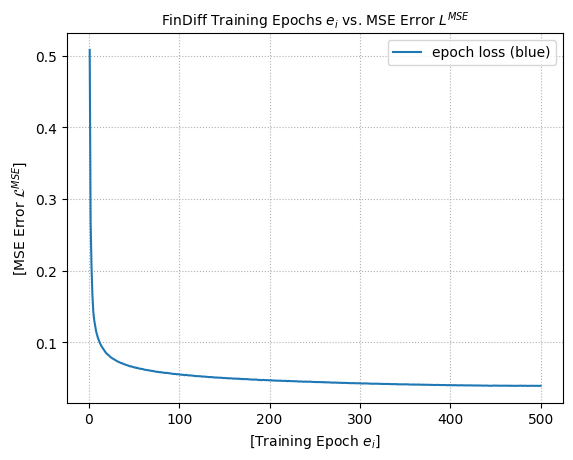

In [46]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel('[Training Epoch $e_i$]', fontsize=10)
ax.set_ylabel('[MSE Error $\mathcal{L}^{MSE}$]', fontsize=10)

# set plot legend
plt.legend(loc='upper right', numpoints=1, fancybox=True)

# add plot title
plt.title('FinDiff Training Epochs $e_i$ vs. MSE Error $L^{MSE}$', fontsize=10);

In [47]:
# init samples to be generated
samples = torch.randn((len(label_torch), encoded_dim), device=device)
labels_list = label_torch.cpu().numpy()

# init the generation progress bar
pbar = tqdm(iterable=reversed(range(0, diffusion_steps)), position=0, leave=True)

with torch.no_grad():
  # iterate over diffusion steps
  for diffusion_step in pbar:

      # prepare and set training epoch progress bar update
      now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
      pbar.set_description('[LOG {}] Diffusion Step: {}'.format(str(now), str(diffusion_step).zfill(4)))

      # init diffusion timesteps
      timesteps = torch.full((len(label_torch),), diffusion_step, dtype=torch.long, device=device)

      # run synthesizer model forward pass
      model_out = synthesizer_model(x=samples.float(), timesteps=timesteps, label=label_torch.to(device))

      # run diffuser model forward pass
      samples = diffuser_model.p_sample_gauss(model_out, samples, timesteps)





[LOG 2024-12-10 23:23:24] Diffusion Step: 0000: : 500it [03:52,  2.15it/s]


In [48]:
# split sample into numeric and categorical parts
samples = samples.detach().cpu().numpy()
samples_num = samples[:, cat_dim:]
samples_cat = samples[:, :cat_dim]

# denormalize numeric attributes
z_norm_upscaled = num_scaler.inverse_transform(samples_num)
z_norm_df = pd.DataFrame(z_norm_upscaled, columns=num_attrs)

# get embedding lookup matrix
embedding_lookup = synthesizer_model.get_embeddings().cpu()

# reshape back to batch_size * n_dim_cat * cat_emb_dim
samples_cat = samples_cat.reshape(-1, len(cat_attrs), cat_emb_dim)

# compute pairwise distances
distances = torch.cdist(x1=embedding_lookup, x2=torch.Tensor(samples_cat))

# get the closest distance based on the embeddings that belong to a column category
z_cat_df = pd.DataFrame(index=range(len(samples_cat)), columns=cat_attrs)

nearest_dist_df = pd.DataFrame(index=range(len(samples_cat)), columns=cat_attrs)

# iterate over categorical attributes
for attr_idx, attr_name in enumerate(cat_attrs):

    attr_emb_idx = list(vocab_per_attr[attr_name])
    attr_distances = distances[:, attr_emb_idx, attr_idx]

    nearest_values, nearest_idx = torch.min(attr_distances, dim=1)
    nearest_idx = nearest_idx.cpu().numpy()

    z_cat_df[attr_name] = np.array(attr_emb_idx)[nearest_idx]  # need to map emb indices back to column indices
    nearest_dist_df[attr_name] = nearest_values.cpu().numpy()

z_cat_df = z_cat_df.apply(label_encoder.inverse_transform)

samples_decoded = pd.concat([z_cat_df, z_norm_df], axis=1)
samples_decoded['Label'] = label_encoder1.inverse_transform(labels_list)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but QuantileTransformer was fitted with feature names



In [49]:
samples_decoded

,Protocol,Dst_Port,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Bwd_Packet_Length_Max,...,FWD_Init_Win_Bytes,Bwd_Init_Win_Bytes,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Idle_Std,ICMP_Code,ICMP_Type,Total_TCP_Flow_Time,Label
0,Protocol_6,80.0,1.239728e+05,5.0,5.0,408.135284,415.000000,0.000000,82.690422,935.00000,...,26883.0,237.0,32.0,0.0000,0.0,0.0,-1.0,-1.0,1.234956e+05,ATTACK
1,Protocol_6,80.0,1.128893e+05,5.0,5.0,308.847900,309.000000,0.000000,62.179329,935.00000,...,26883.0,237.0,32.0,0.0000,0.0,0.0,-1.0,-1.0,1.144519e+05,ATTACK
2,Protocol_6,80.0,1.078504e+05,5.0,5.0,375.000000,386.020081,0.000000,75.000000,935.00000,...,26883.0,237.0,32.0,0.0000,0.0,0.0,-1.0,-1.0,1.128959e+05,ATTACK
3,Protocol_6,80.0,1.986057e+05,5.0,5.0,305.000000,305.000000,0.000000,61.799999,935.00000,...,26883.0,237.0,32.0,0.0000,0.0,0.0,-1.0,-1.0,1.923236e+05,ATTACK
4,Protocol_6,80.0,1.731564e+05,5.0,5.0,332.000000,333.000000,0.000000,67.258148,935.00000,...,26883.0,219.0,32.0,0.0000,0.0,0.0,-1.0,-1.0,1.745937e+05,ATTACK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455864,Protocol_6,443.0,2.991873e+07,6.0,4.0,309.000000,161.000000,0.000000,37.000000,64.20192,...,257.0,211.0,20.0,104461.9375,0.0,0.0,-1.0,-1.0,1.728377e+08,BENIGN
455865,Protocol_6,80.0,1.346764e+05,5.0,5.0,358.000000,363.000000,0.000000,71.599998,935.00000,...,26883.0,237.0,32.0,0.0000,0.0,0.0,-1.0,-1.0,1.359550e+05,ATTACK
455866,Protocol_6,80.0,1.137165e+05,5.0,5.0,321.839905,321.000000,0.000000,65.199997,935.00000,...,26883.0,237.0,32.0,0.0000,0.0,0.0,-1.0,-1.0,1.154250e+05,ATTACK
455867,Protocol_6,3389.0,4.335016e+06,8.0,9.0,1148.000000,661.000000,0.000000,141.684921,1173.00000,...,8192.0,62856.0,20.0,0.0000,0.0,0.0,-1.0,-1.0,3.080589e+06,BENIGN


In [50]:
print("Nombre de doublons dans 'data' :", samples_decoded.duplicated().sum())

Nombre de doublons dans 'data' : 0


In [51]:
samples_decoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455869 entries, 0 to 455868
Data columns (total 53 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Protocol                    455869 non-null  object 
 1   Dst_Port                    455869 non-null  float32
 2   Flow_Duration               455869 non-null  float32
 3   Total_Fwd_Packet            455869 non-null  float32
 4   Total_Bwd_packets           455869 non-null  float32
 5   Total_Length_of_Fwd_Packet  455869 non-null  float32
 6   Fwd_Packet_Length_Max       455869 non-null  float32
 7   Fwd_Packet_Length_Min       455869 non-null  float32
 8   Fwd_Packet_Length_Mean      455869 non-null  float32
 9   Bwd_Packet_Length_Max       455869 non-null  float32
 10  Bwd_Packet_Length_Min       455869 non-null  float32
 11  Bwd_Packet_Length_Mean      455869 non-null  float32
 12  Flow_Bytes_s                455869 non-null  float32
 13  Flow_Packets_s

In [52]:
# Specify the file path and file name
output_file = '/kaggle/working/generated_dataset.csv'

# Save the DataFrame to a CSV file
samples_decoded.to_csv(output_file, index=False)

print(f"Dataset saved to {output_file}")


Dataset saved to /kaggle/working/generated_dataset.csv


In [39]:
# build a metadata for evaluation (from SDV)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train_raw)

# generate quality report
quality_report = sdv_st.evaluate_quality(
    real_data=train_raw,
    synthetic_data=samples_decoded,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 53/53 [00:12<00:00,  4.20it/s]|
Column Shapes Score: 96.19%

(2/2) Evaluating Column Pair Trends: |██████████| 1378/1378 [01:14<00:00, 18.43it/s]|
Column Pair Trends Score: 93.16%

Overall Score (Average): 94.68%



In [40]:
# plot Column Shapes -> referred to the "Fidelity Column" in the paper
fig = quality_report.get_visualization(property_name='Column Shapes')
fig.show()

In [41]:
# plot Column Pair Trends -> referred to the "Fidelity Row" in the paper
fig = quality_report.get_visualization(property_name='Column Pair Trends')
fig.show()

In [53]:
data=samples_decoded

In [ ]:
common_rows = pd.merge(samples_decoded, train_raw, how='inner')

# Compter le nombre de lignes similaires
count_common_rows = len(common_rows)

print(f"Nombre de lignes similaires entre les deux datasets : {count_common_rows}")
